# 1D example

Visualization of Gaussian process regression (GPR) using LightGPR on 1D data.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from LightGPR.gp_reg import gp_reg
from LightGPR.kernels import RQ_kernel

Generate some 1D dataset

In [30]:
Xtrain_1D = np.random.uniform(0, 10, size=5) # Design vector / features
ytrain_1D = np.sin(Xtrain_1D) # Target values / labels

Create a GPR model and supply the dataset. The default prior mean function is $\mu_{\text{Prior}}(x) = 0$ and the default prior covariance (kernel) function is the RBF kernel.

In [31]:
prior_mean_func = lambda x: -np.sin(x) # 1D prior mean function
model_1D = gp_reg(Xtrain_1D, ytrain_1D, prior_mean=prior_mean_func)#, kernel=RQ_kernel)

Train the GPR model. The hyperparameters of the kernel are then optimized via maximum likelihood method.

In [32]:
model_1D.train()
print(f"Loss: {model_1D.loss}, Outputscale: {model_1D.outputscale}, Hyperparams: {model_1D.kernel.hyperparams}, Noise: {model_1D.ynoise}")

Loss: 2.7665220763370404, Outputscale: 1.4227713539677773, Hyperparams: [1.1371891], Noise: 1e-10


Make predictions with the trained GPR model at test locations `Xtest_1D`. The method `predict(Xtest_1D)` returns the posterior mean (regression) and variance (square of the uncertainty) at the test locations.

In [33]:
Xtest_1D = np.linspace(0, 10, 1000)
mean_post_1D, var_post_1D = model_1D.predict(Xtest_1D)

Plot the results

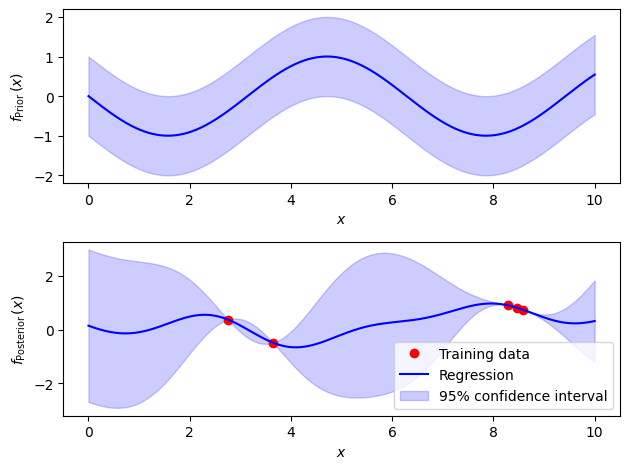

In [34]:

fig, ax = plt.subplots(2, 1)
ax[0].plot(Xtest_1D, prior_mean_func(Xtest_1D), 'b-', label='Prior mean')
ax[0].fill_between(Xtest_1D, prior_mean_func(Xtest_1D) - 1, prior_mean_func(Xtest_1D) + 1, color='b', alpha=0.2, label='95% confidence interval')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$f_{\text{Prior}} \, (x)$')

ax[1].plot(Xtrain_1D, ytrain_1D, 'ro', label='Training data')
ax[1].plot(Xtest_1D, mean_post_1D, 'b-', label='Regression')
ax[1].fill_between(Xtest_1D, mean_post_1D - 2*np.sqrt(var_post_1D), mean_post_1D + 2*np.sqrt(var_post_1D), color='b', alpha=0.2, label='95% confidence interval')
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$f_{\text{Posterior}} \, (x)$')
ax[1].legend()
fig.tight_layout()
plt.show()

# 2D example

Higher-dimensional datasets are treated analogously:

In [51]:
# 2D target function
target_func = lambda x: np.sin(x[:,0]) + np.cos(x[:,1])

# Generate some 2D dataset
Xtrain = np.random.rand(5,2) # Design matrix / features
ytrain = target_func(Xtrain) # Target values / labels

# Create GPR model
model = gp_reg(Xtrain, ytrain, kernel=RQ_kernel)

# Train GPR model
model.train()
print(f"Loss: {model.loss}, Outputscale: {model.outputscale}, Hyperparams: {model.kernel.hyperparams}, Noise: {model.ynoise}")

Loss: -3.227420987556684, Outputscale: 1.678466726613262, Hyperparams: [  2.72534556 100.        ], Noise: 1e-10


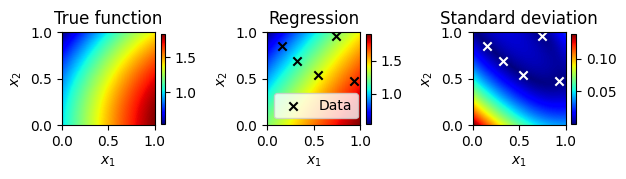

In [52]:
# Make predictions at test points
test_grid = np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))
Xtest = np.array(list(zip(test_grid[0].ravel(), test_grid[1].ravel())))
mean_post, var_post = model.predict(Xtest)

# Plot results
fig, ax = plt.subplots(1, 3)
im0 = ax[0].imshow(target_func(Xtest).reshape(test_grid[0].shape), cmap='jet', extent=[0,1,0,1], origin='lower')
fig.colorbar(im0, ax=ax[0], shrink=0.2)
ax[0].set_title('True function')
ax[0].set_ylabel(r'$x_2$')
ax[0].set_xlabel(r'$x_1$')

im1 = ax[1].imshow(mean_post.reshape(test_grid[0].shape), cmap='jet', extent=[0,1,0,1], origin='lower')
ax[1].scatter(Xtrain[:,0], Xtrain[:,1], c='k', marker='x', label='Data')
fig.colorbar(im1, ax=ax[1], shrink=0.2)
ax[1].set_title('Regression')
ax[1].set_ylabel(r'$x_2$')
ax[1].set_xlabel(r'$x_1$')
ax[1].legend()

im2 = ax[2].imshow(np.sqrt(var_post).reshape(test_grid[0].shape), cmap='jet', extent=[0,1,0,1], origin='lower')
ax[2].scatter(Xtrain[:,0], Xtrain[:,1], c='w', marker='x', label='Data')
fig.colorbar(im2, ax=ax[2], shrink=0.2)
ax[2].set_title('Standard deviation')
ax[2].set_ylabel(r'$x_2$')
ax[2].set_xlabel(r'$x_1$')
fig.tight_layout()
plt.show()

# Custom kernel functions

A special use case for LightGPR are custom kernel functions, such as non-stationary kernels. These can be added into the `kernel.py` file. Additionally, the existing RBF and RQ kernels can be transformed using the `.kernel.nonstat_fct` attribute, i.e.,
$$ k_{\text{new}}(\mathbf{x}, \mathbf{x}^\prime) = B(\mathbf{x}) \, k(\mathbf{x}, \mathbf{x}^\prime) \, B(\mathbf{x}^\prime) , $$
where `.kernel.nonstat_fct` takes a function defining $B(\mathbf{x})$.

As a demonstration, we define a function which is zero at $x_i = L_1$ and $x_i = L_2$ along each dimension $i = 1, 2, \dots$:

In [53]:
L1, L2 = 0, 1
B_box = lambda X: np.prod(np.abs(X - L1*np.ones(len(X[0]))) * np.abs(X - L2*np.ones(len(X[0]))), axis=1)

Using this function, we can create a GP which is zero along the edges of a higher-dimensional box with edge lengths $\Delta L = 1$. To do so, we need to multiply our prior mean function by this function as well.

In [44]:
# 2D prior mean function with zero boundaries
prior_mean_func = lambda x: B_box(x) * (np.sin(x[:,0]) + np.cos(x[:,1]))

# 2D target function
target_func = lambda x: np.sin(2*np.pi*x[:,0]) * np.sin(np.pi*x[:,1])

# Generate some 2D dataset
Xtrain = np.random.uniform(low=0, high=1, size=(5,2)) # Design matrix / features
ytrain = target_func(Xtrain) # Target values / labels

# Create GPR model with zero box boundary
model = gp_reg(Xtrain, ytrain, prior_mean=prior_mean_func)
model.kernel.nonstat_fct = B_box

# Train GPR model
model.train()
print(f"Loss: {model.loss}, Outputscale: {model.outputscale}, Hyperparams: {model.kernel.hyperparams}, Noise: {model.ynoise}")

Loss: -7.835405128334148, Outputscale: 18.750121965967825, Hyperparams: [ 0.43204257 99.99926612], Noise: 0.0013180301010827919


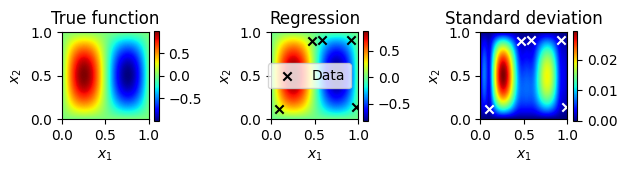

In [45]:
# Make predictions at test points
test_grid = np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))
Xtest = np.array(list(zip(test_grid[0].ravel(), test_grid[1].ravel())))
mean_post, var_post = model.predict(Xtest)

# Plot results
fig, ax = plt.subplots(1, 3)
im0 = ax[0].imshow(target_func(Xtest).reshape(test_grid[0].shape), cmap='jet', extent=[0,1,0,1], origin='lower')
fig.colorbar(im0, ax=ax[0], shrink=0.2)
ax[0].set_title('True function')
ax[0].set_ylabel(r'$x_2$')
ax[0].set_xlabel(r'$x_1$')

im1 = ax[1].imshow(mean_post.reshape(test_grid[0].shape), cmap='jet', extent=[0,1,0,1], origin='lower')
ax[1].scatter(Xtrain[:,0], Xtrain[:,1], c='k', marker='x', label='Data')
fig.colorbar(im1, ax=ax[1], shrink=0.2)
ax[1].set_title('Regression')
ax[1].set_ylabel(r'$x_2$')
ax[1].set_xlabel(r'$x_1$')
ax[1].legend()

im3 = ax[2].imshow(np.sqrt(var_post).reshape(test_grid[0].shape), cmap='jet', extent=[0,1,0,1], origin='lower')
ax[2].scatter(Xtrain[:,0], Xtrain[:,1], c='w', marker='x', label='Data')
fig.colorbar(im3, ax=ax[2], shrink=0.2)
ax[2].set_title('Standard deviation')
ax[2].set_ylabel(r'$x_2$')
ax[2].set_xlabel(r'$x_1$')
fig.tight_layout()
plt.show()